# INF264 - Obligatory assignment 3: Sequence Models

By Einar Bernsen and Johannes Skivdal

Initial imports:

In [1]:
import os
import re
import random
import heapq

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
from tqdm import trange


seed = 265
torch.manual_seed(seed)

d:\conda\envs\inf265_ob3\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
d:\conda\envs\inf265_ob3\Lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
d:\conda\envs\inf265_ob3\Lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is d

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

#### Defining global variables

In [3]:
TRAINING = True
CONTEXT_SIZE = 6
EMBEDDING_SIZE = 16
SAVE_PATH = "./save_folder/"
TOKENIZER_EN = get_tokenizer("basic_english")

In [4]:
# Inspired from the tutorial
def read_files(datapath="./data_train/"):
    """
    Return a list of strings, one for each line in each .txt files in 'datapath'
    """
    # Find all txt files in directory
    files = os.listdir(datapath)
    files = [datapath + f for f in files if f.endswith(".txt")]

    # Stores each line of each book in a list
    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines

In [5]:
files_read = read_files()

In [6]:
len(files_read)

268380

In [7]:
def tokenize_dataset(datapath):
    # Get all files from the dataset
    files = os.listdir(datapath)
    files = [datapath + f for f in files if f.endswith(".txt")]

    # Read all the lines into a list
    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()

    # Tokenize every line
    tokenized_lines = []
    for line in lines:
        tokenized_lines += TOKENIZER_EN(line)

    # Return both, incase you want the original lines too.
    return tokenized_lines, lines

In [8]:
# No need to save and load here, lightweight to compute.
train_token, train_lines = tokenize_dataset("./data_train/")
val_token, val_lines = tokenize_dataset("./data_val/")
test_token, test_lines = tokenize_dataset("./data_test/")

In [9]:
print("Total number of words in the training dataset:     ", len(train_token))
print("Total number of words in the validation dataset:   ", len(val_token))
print("Total number of words in the test dataset:         ", len(test_token))

Total number of words in the training dataset:      2684706
Total number of words in the validation dataset:    49526
Total number of words in the test dataset:          124152


In [10]:
# From tutorial
def yield_tokens(lines, tokenizer=TOKENIZER_EN):
    """
    Yield tokens, ignoring names and digits to build vocabulary
    """
    # Match any word containing digit
    no_digits = "\w*[0-9]+\w*"
    # Match word containing a uppercase
    no_names = "\w*[A-Z]+\w*"
    # Match any sequence containing more than one space
    no_spaces = "\s+"

    for line in lines:
        line = re.sub(no_digits, " ", line)
        line = re.sub(no_names, " ", line)
        line = re.sub(no_spaces, " ", line)
        yield tokenizer(line)


def create_vocabulary(lines, min_freq=100):
    """
    Create a vocabulary (list of known tokens) from a list of strings
    """
    # vocab contains the vocabulary found in the data, associating an index to each word
    vocab = build_vocab_from_iterator(
        yield_tokens(lines), min_freq=min_freq, specials=["<unk>"]
    )
    # Since we removed all words with an uppercase when building the vocabulary, we skipped the word "I"
    vocab.append_token("i")
    # Value of default index. This index will be returned when OOV (Out Of Vocabulary) token is queried.
    vocab.set_default_index(vocab["<unk>"])
    return vocab

In [11]:
# Saving and loading the vocab
if os.path.isfile(SAVE_PATH + "train_vocab.pt"):
    train_vocab = torch.load(SAVE_PATH + "train_vocab.pt")
else:
    # Creating the vocab
    train_vocab = create_vocabulary(train_lines)
    torch.save(train_vocab, SAVE_PATH + "train_vocab.pt")

In [12]:
print("Total number of words in the training dataset:     ", len(train_token))
print("Number of distinct words in the training dataset:  ", len(set(train_token)))
print("The size of the defined vocabulary:                ", len(train_vocab))

Total number of words in the training dataset:      2684706
Number of distinct words in the training dataset:   52105
The size of the defined vocabulary:                 1880


In [13]:
# "I" is not in the vocab, so it will have index 0, that stands for unknown word.
train_vocab["I"]

0

### Function for creating datasets

Instead of excluding all banned words, we could introduse some RNG to determine when to exclude.

In [14]:
# Creating a list of the indexes that should be excluded
banned_words = train_vocab.lookup_indices(["<ukn>", ".", ",", "(", ")", "?", "!"])

In [15]:
def create_tensor_dataset(dataset):
    context_data = torch.tensor([ex[0] for ex in dataset])
    target_data = torch.tensor([ex[1] for ex in dataset])
    dataset = TensorDataset(context_data, target_data)
    return dataset, context_data, target_data

In [16]:
torch.cat((torch.empty(0), torch.tensor([1]), torch.tensor([0])), dim=0)

tensor([1., 0.])

In [17]:
# Takes in the tokenised data and a vocabulary. Then creates context and target pairs, based on the context size and what position the target should have to the context.
def create_dataset(tokens, vocab, context_size, banned_words=[-1], only_words=None, position='middle'):
    # The position needs to be defined by the following
    assert position in [
        "middle",
        "behind",
        "ahead",
    ], """Position needs to either 'middle', 'behind' or 'ahead'."""

    data = []

    token_len = len(tokens)

    if only_words:
        TARGET_MAP = {only_words[i]: i for i in range(len(only_words))}

    if position == "middle":
        window_size = context_size // 2
        end_pos = token_len - window_size
        start_pos = window_size

    elif position == "ahead":
        end_pos = token_len
        start_pos = context_size

    elif position == "behind":
        end_pos = token_len - context_size
        start_pos = 0

    for i in range(start_pos, end_pos):
        if train_vocab[tokens[i]] in banned_words:
            continue

        if only_words:
            if tokens[i] not in only_words:
                continue

        if position == "middle":
            context = tokens[i - window_size : i] + tokens[i + 1 : i + window_size + 1]

        elif position == "ahead":
            context = tokens[i - context_size : i]

        elif position == "behind":
            context = tokens[i + 1 : i + context_size + 1]

        if only_words:
            target_idx = TARGET_MAP[tokens[i]]
        else:
            target = tokens[i]
            target_idx = vocab[target]

        context_idxs = [vocab[x] for x in context]
        
        data.append((context_idxs, target_idx))

    context_data = torch.tensor([ex[0] for ex in data])
    target_data = torch.tensor([ex[1] for ex in data])
    dataset = TensorDataset(context_data, target_data)

    return dataset, context_data, target_data

In [18]:
train_dataset = create_dataset(
    train_token, train_vocab, CONTEXT_SIZE, banned_words, position="middle"
)

In [19]:
# Quite the amount of data removed
len(train_dataset[0]), len(train_token)
#(1917177, 2684706)

(1917177, 2684706)

### Implementing CBOW

In [20]:
class CBOW(nn.Module):
    def __init__(
        self, emb_dim=EMBEDDING_SIZE, context_size=CONTEXT_SIZE, vocab_size=-1
    ):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, emb_dim)
        self.fc1 = nn.Linear(emb_dim * context_size, 128)
        self.fc2 = nn.Linear(128, vocab_size)

    def forward(self, x):
        embeddings = torch.flatten(self.embeddings(x), 1)
        x = F.relu(self.fc1(embeddings))
        x = F.relu(self.fc2(x))
        return x

### Model selection

In [21]:
# Read through: https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75
# Using inversely proportional frequency
def compute_class_weights(targets):
    class_counts = torch.tensor(np.bincount(targets))
    class_counts = class_counts.masked_fill(class_counts == 0, 999999999)
    
    return targets.size(0) / class_counts

In [22]:
def train_cbow(
    epochs,
    train_dataloader,
    emb_dim=EMBEDDING_SIZE,
    context_size=CONTEXT_SIZE,
    lr=0.001,
    loss_weights = None
):
    print("Starting training")
    
    torch.manual_seed(seed)
    cbow_model = CBOW(
        vocab_size=len(train_vocab), emb_dim=emb_dim, context_size=context_size
    ).to(device)
    optimizer = optim.Adam(cbow_model.parameters(), lr=lr)
    loss_fnc = nn.CrossEntropyLoss(weight=loss_weights).to(device)

    print(
        f"\nStarting training with emb_dim = {emb_dim}, context_size = {context_size}: "
    )
    for epoch in trange(epochs, desc="Epoch"):
        for context, target in train_dataloader:
            context = context.to(device)
            target = target.to(device)

            output = cbow_model(context)
            loss = loss_fnc(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}, Loss {loss}")

    return cbow_model

In [23]:
def evaluate_model_dataloader(model_temp, dataloader, hidden_arg=None):
    accuracy = 0

    with torch.no_grad():
        model_temp.eval()

        for context, target in dataloader:
            context = context.to(device)
            target = target.to(device)

            if hidden_arg:
                hidden = model.init_hidden(len(target)).to(device)
                output, _ = model_temp(context,hidden)
            else:
                output = model_temp(context)

            accuracy += (
                torch.nan_to_num(output.argmax(dim=1) == target).count_nonzero()
                / dataloader.batch_size
            )

    return accuracy / len(dataloader)

In [24]:
def evaluate_model(cbow_model, train_dataloader, val_dataloader):
    print("Starting evaluation")
    train_accuracy = 0
    val_accuracy = 0
    with torch.no_grad():
        cbow_model.eval()

        print("\nComputing training accuracy")
        train_accuracy = evaluate_model_dataloader(cbow_model, train_dataloader)
        print("done")

        print("\nComputing validation accuracy")
        val_accuracy = evaluate_model_dataloader(cbow_model, val_dataloader)
        print("done")

    print("Model scored following results")
    print("Train accuracy: ", train_accuracy)
    print("Val accuracy: ", val_accuracy)

In [25]:
def save_load(filepath, saving_item=None, force_save=False):
    if not os.path.isfile(filepath) or force_save:
        torch.save(saving_item, filepath)
    else:
        saving_item = torch.load(filepath)

    return saving_item

In [26]:
def save_load_model(filepath, model_instance=None, model=None, force_save=False):
    if not os.path.isfile(filepath) or force_save:
        torch.save(model, filepath)
    else:
        assert (
            model_instance
        ), "If you want overwrite an existing model, then enter force_save=True"

        model = model_instance
        model.load_state_dict(torch.load(filepath).state_dict())

    return model

#### Creating grid search

In [27]:
def train_cbow_grid(epochs, context_sizes: list, embedding_sizes: list, use_class_weights=False):
    models_result = {}

    best_model = None
    best_params = None
    best_model_perf = 0.0

    for con_size in context_sizes:
        print(f"\nCreating datasets for context size: {con_size}: ")
        train_dataset_temp, _, train_targets = create_dataset(
            train_token, train_vocab, con_size, banned_words, position="middle"
        )
        val_dataset_temp, _, _ = create_dataset(
            val_token, train_vocab, con_size, banned_words, position="middle"
        )

        train_dataloader = DataLoader(train_dataset_temp, batch_size=1024, shuffle=True)
        val_dataloader = DataLoader(val_dataset_temp, batch_size=1024, shuffle=True)
        print("Datasets created")

        if use_class_weights == True:
            class_weights = compute_class_weights(train_targets)
        else:
            class_weights = None

        for emb_size in embedding_sizes:
            model = train_cbow(
                epochs, train_dataloader, emb_dim=emb_size, context_size=con_size, loss_weights=class_weights
            )
            validation_performance = evaluate_model_dataloader(model, val_dataloader)

            results_info = {}

            results_info["Parameters"] = {"con_size": con_size, "emb_size": emb_size}
            results_info["Val_perf"] = validation_performance.item()

            if validation_performance.item() > best_model_perf:
                best_model_perf = validation_performance.item()
                best_model = model
                best_params = (con_size, emb_size)

            models_result[f"{con_size},{emb_size}"] = results_info

    return best_model, best_params, best_model_perf, models_result

Skip these next 5 cells if not TRAINING==True

In [29]:
if TRAINING:
    best_model, best_params, best_model_perf, models_result = train_cbow_grid(
        10, context_sizes=[4, 6], embedding_sizes=[12, 16], use_class_weights=False
    )


Creating datasets for context size: 4: 
Datasets created
Starting training

Starting training with emb_dim = 12, context_size = 4: 


Epoch:  10%|█         | 1/10 [00:11<01:39, 11.04s/it]

Epoch 0, Loss 4.387630939483643


Epoch:  20%|██        | 2/10 [00:21<01:26, 10.76s/it]

Epoch 1, Loss 4.061700344085693


Epoch:  30%|███       | 3/10 [00:31<01:13, 10.53s/it]

Epoch 2, Loss 4.032505512237549


Epoch:  40%|████      | 4/10 [00:42<01:03, 10.50s/it]

Epoch 3, Loss 3.9217262268066406


Epoch:  50%|█████     | 5/10 [00:52<00:52, 10.47s/it]

Epoch 4, Loss 4.206316947937012


Epoch:  60%|██████    | 6/10 [01:02<00:41, 10.34s/it]

Epoch 5, Loss 3.8075170516967773


Epoch:  70%|███████   | 7/10 [01:13<00:31, 10.42s/it]

Epoch 6, Loss 4.459645748138428


Epoch:  80%|████████  | 8/10 [01:23<00:20, 10.35s/it]

Epoch 7, Loss 4.14863920211792


Epoch:  90%|█████████ | 9/10 [01:33<00:10, 10.24s/it]

Epoch 8, Loss 4.2407708168029785


Epoch: 100%|██████████| 10/10 [01:43<00:00, 10.36s/it]


Epoch 9, Loss 3.8415980339050293
Starting training

Starting training with emb_dim = 16, context_size = 4: 


Epoch:  10%|█         | 1/10 [00:10<01:31, 10.18s/it]

Epoch 0, Loss 4.608013153076172


Epoch:  20%|██        | 2/10 [00:20<01:22, 10.35s/it]

Epoch 1, Loss 4.472213268280029


Epoch:  30%|███       | 3/10 [00:30<01:11, 10.19s/it]

Epoch 2, Loss 4.12794303894043


Epoch:  40%|████      | 4/10 [00:40<01:00, 10.12s/it]

Epoch 3, Loss 4.20465612411499


Epoch:  50%|█████     | 5/10 [00:50<00:50, 10.12s/it]

Epoch 4, Loss 3.6004111766815186


Epoch:  60%|██████    | 6/10 [01:00<00:40, 10.11s/it]

Epoch 5, Loss 4.327670097351074


Epoch:  70%|███████   | 7/10 [01:10<00:30, 10.02s/it]

Epoch 6, Loss 4.000092506408691


Epoch:  80%|████████  | 8/10 [01:20<00:20, 10.04s/it]

Epoch 7, Loss 4.086477756500244


Epoch:  90%|█████████ | 9/10 [01:30<00:10, 10.06s/it]

Epoch 8, Loss 4.012253284454346


Epoch: 100%|██████████| 10/10 [01:40<00:00, 10.10s/it]

Epoch 9, Loss 3.9939897060394287

Creating datasets for context size: 6: 


Datasets created
Starting training

Starting training with emb_dim = 12, context_size = 6: 


Epoch:  10%|█         | 1/10 [00:10<01:30, 10.10s/it]

Epoch 0, Loss 4.774755477905273


Epoch:  20%|██        | 2/10 [00:20<01:19,  9.98s/it]

Epoch 1, Loss 4.586620807647705


Epoch:  30%|███       | 3/10 [00:29<01:09,  9.89s/it]

Epoch 2, Loss 4.381562232971191


Epoch:  40%|████      | 4/10 [00:40<01:00, 10.04s/it]

Epoch 3, Loss 4.230799674987793


Epoch:  50%|█████     | 5/10 [00:50<00:50, 10.14s/it]

Epoch 4, Loss 4.152810096740723


Epoch:  60%|██████    | 6/10 [01:00<00:40, 10.20s/it]

Epoch 5, Loss 4.134964942932129


Epoch:  70%|███████   | 7/10 [01:10<00:30, 10.08s/it]

Epoch 6, Loss 4.344654083251953


Epoch:  80%|████████  | 8/10 [01:20<00:20, 10.05s/it]

Epoch 7, Loss 4.138851165771484


Epoch:  90%|█████████ | 9/10 [01:30<00:10, 10.02s/it]

Epoch 8, Loss 4.5815205574035645


Epoch: 100%|██████████| 10/10 [01:40<00:00, 10.07s/it]


Epoch 9, Loss 4.1146240234375
Starting training

Starting training with emb_dim = 16, context_size = 6: 


Epoch:  10%|█         | 1/10 [00:10<01:32, 10.30s/it]

Epoch 0, Loss 4.449157238006592


Epoch:  20%|██        | 2/10 [00:20<01:22, 10.27s/it]

Epoch 1, Loss 4.151708126068115


Epoch:  30%|███       | 3/10 [00:30<01:10, 10.13s/it]

Epoch 2, Loss 4.403507232666016


Epoch:  40%|████      | 4/10 [00:40<01:00, 10.09s/it]

Epoch 3, Loss 3.892160177230835


Epoch:  50%|█████     | 5/10 [00:50<00:50, 10.02s/it]

Epoch 4, Loss 3.8412320613861084


Epoch:  60%|██████    | 6/10 [01:00<00:40, 10.08s/it]

Epoch 5, Loss 4.031732559204102


Epoch:  70%|███████   | 7/10 [01:10<00:30, 10.04s/it]

Epoch 6, Loss 4.298315048217773


Epoch:  80%|████████  | 8/10 [01:20<00:20, 10.02s/it]

Epoch 7, Loss 4.211244106292725


Epoch:  90%|█████████ | 9/10 [01:30<00:10, 10.02s/it]

Epoch 8, Loss 4.039017200469971


Epoch: 100%|██████████| 10/10 [01:40<00:00, 10.06s/it]

Epoch 9, Loss 3.8218367099761963


In [30]:
best_model_key = max(models_result, key=lambda key: models_result[key]["Val_perf"])
best_model_key, models_result[best_model_key]["Val_perf"]

('6,16', 0.2871907651424408)

In [31]:
best_model

CBOW(
  (embeddings): Embedding(1880, 16)
  (fc1): Linear(in_features=96, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1880, bias=True)
)

In [32]:
for i, key in enumerate(
    sorted(models_result, key=lambda key: models_result[key]["Val_perf"], reverse=True)
):
    print(f"""#{i+1}: {key} with {models_result[key]['Val_perf']:.4f}% on validation""")

#1: 6,16 with 0.2872% on validation
#2: 6,12 with 0.2847% on validation
#3: 4,16 with 0.2843% on validation
#4: 4,12 with 0.2746% on validation


In [33]:
CONTEXT_SIZE, EMBEDDING_SIZE = best_params  # (6, 16)
CONTEXT_SIZE, EMBEDDING_SIZE

(6, 16)

Start from here if TRAINING=False

In [34]:
if TRAINING:
    save_load_model(
        filepath=SAVE_PATH + "CBOW_model.pth", model=best_model, force_save=True
    )
    embedding_weights = best_model.embeddings.weight
    embedding_dict = best_model.embeddings.state_dict()

    embedding_weights = save_load(SAVE_PATH + "CBOW_embeddings.pt", saving_item=embedding_weights, force_save=True)
    embedding_dict = save_load(SAVE_PATH + "CBOW_embeddings_dict.pt", saving_item=embedding_dict, force_save=True)
else:
    best_model = torch.load(SAVE_PATH + "CBOW_model.pth")
    embedding_weights = best_model.embeddings.weight
    embedding_dict = best_model.embeddings.state_dict()

#### Evaluating on unseen data

In [35]:
test_dataset_temp, _, _ = create_dataset(
    test_token, train_vocab, CONTEXT_SIZE, banned_words, position="middle"
)

test_dataloader = DataLoader(test_dataset_temp, batch_size=1024, shuffle=True)

In [36]:
print(f'Model performance on unseen test data: {evaluate_model_dataloader(best_model, test_dataloader).item():.4f}%')

Model performance on unseen test data: 0.2915%


### Checking similarities between the words using the embeddings

In [37]:
nn.CosineSimilarity(dim=1)(embedding_weights[0], embedding_weights)

tensor([ 1.0000, -0.1986, -0.1889,  ...,  0.2937,  0.4111, -0.0624],
       device='cuda:0', grad_fn=<SumBackward1>)

In [38]:
similarities = {}
for word in range(len(train_vocab)):
    similarities[train_vocab.lookup_tokens([word])[0]] = torch.topk(
        nn.CosineSimilarity(dim=1)(embedding_weights[word], embedding_weights), 11
    )[1][1:].tolist()

In [40]:
vocab_words = train_vocab.lookup_tokens(range(len(train_vocab)))

In [41]:
def similarity_checker(in_word=None):
    if in_word:
        word_sim = in_word
    else:
        word_sim = random.choice(vocab_words)
    print("\nThe word:", word_sim)
    print("The similar words: ", train_vocab.lookup_tokens(similarities[word_sim]))

In [43]:
similarity_checker("king"), similarity_checker("queen"), similarity_checker("boy"), similarity_checker("girl")


The word: king
The similar words:  ['earl', 'count', 'prince', 'weather', 'bishop', 'princess', 'wind', 'general', 'dwarf', 'latter']

The word: queen
The similar words:  ['horses', 'artillery', 'leaves', 'houses', 'darkness', 'dogs', 'water', 'money', 'doctor', 'shore']

The word: boy
The similar words:  ['brother', 'dog', 'beast', 'ship', 'master', 'servant', 'story', 'kingdom', 'son', 'company']

The word: girl
The similar words:  ['lady', 'dog', 'creature', 'man', 'gentleman', 'bird', 'laugh', 'fellow', 'letters', 'convent']


(None, None, None, None)

In [45]:
for n in range(1, 10):
    similarity_checker()


The word: motionless
The similar words:  ['names', 'ships', 'troops', 'together', 'influence', 'evident', 'luck', 'sous', 'anger', 'hands']

The word: persons
The similar words:  ['men', 'people', 'women', 'days', 'kings', 'others', 'things', 'hours', 'years', 'sous']

The word: figure
The similar words:  ['son', 'path', 'rope', 'chief', 'impression', 'sons', 'firm', 'kingdom', 'own', 'lot']

The word: eyes
The similar words:  ['fingers', 'mouth', 'legs', 'nose', 'forces', 'tears', 'neck', 'hands', 'shoes', 'shoulders']

The word: whose
The similar words:  ['my', 'your', '-', 'his', 'our', 'their', 'whom', 'de', 'who', 'her']

The word: countess
The similar words:  ['soldiers', 'sun', 'dwarf', 'prince', 'count', 'someone', 'bondes', 'doctor', 'circumstances', 'kings']

The word: fifteen
The similar words:  ['three', 'six', 'forty', 'ten', 'five', 'two', 'social', 'infantry', 'seven', 'eight']

The word: why
The similar words:  ['where', 'how', 'what', 'until', '—', 'however', 'when', 

In [46]:
# To get the embeddings compatible with the tensorflow visual site
embedding_weights_cpu = embedding_weights.clone().to("cpu")


def temp_func(in_list):
    ret_string = ""
    for ele in in_list:
        ret_string += f"{ele}\t"
    return ret_string


with open(SAVE_PATH + "Embedding.TSV", "w") as file:
    for n in range(len(embedding_weights_cpu)):
        file.write(f"{temp_func(embedding_weights_cpu[n])}" + "\n")

with open(SAVE_PATH + "Embedding_names.TSV", "w") as file:
    for n in range(len(embedding_weights_cpu)):
        file.write(f"{train_vocab.lookup_tokens([n])[0]}\n")

# 4 (dependency of 2.2)
## 4.1

In [47]:
def create_pe(context_size, emb_size):
    position_matrix = torch.zeros(context_size, emb_size)
    for i in range(0, context_size - 1):
        for j in range(0, int(emb_size / 2)):
            position_matrix[i, 2 * j] = torch.sin(
                torch.tensor(i / 10000 ** (2 * j / emb_size))
            )
            position_matrix[i, 2 * j + 1] = torch.cos(
                torch.tensor(i / 10000 ** (2 * j / emb_size))
            )
    return position_matrix

In [48]:
pe = create_pe(CONTEXT_SIZE + 100, EMBEDDING_SIZE + 100)

In [49]:
import matplotlib.pyplot as plt

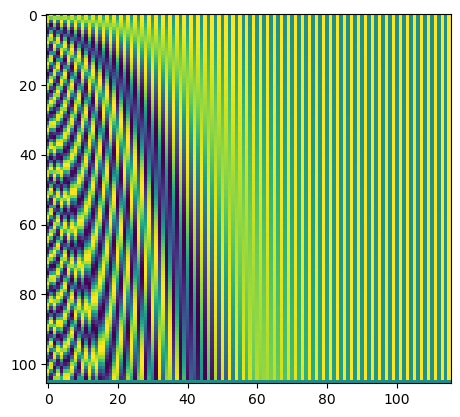

In [50]:
plt.imshow(pe.unsqueeze(0).permute(1, 2, 0))

## 4.2

In [51]:
class SelfAttention(nn.Module):
    def __init__(
        self, emb_dim=EMBEDDING_SIZE, context_size=CONTEXT_SIZE, vocab_size=-1, p=4
    ):
        super().__init__()

        self.p = p
        self.emb_dim = emb_dim

        # Like tutorial 6
        self.embeddings = nn.Embedding(vocab_size, emb_dim)
        self.embeddings.load_state_dict(embedding_dict)

        self.identity_matrix = torch.eye(len(train_vocab))
        # Freeze the layer
        for p in self.embeddings.parameters():
            p.requires_grad = False

        self.pe = create_pe(emb_dim, context_size)

        # Weights in dim PXD
        self.Wq = nn.Parameter(torch.rand(1, emb_dim, self.p), requires_grad=True)

        self.Kq = nn.Parameter(torch.rand(1, emb_dim, self.p), requires_grad=True)

        self.Vq = nn.Parameter(torch.rand(1, emb_dim, self.p), requires_grad=True)

    def forward(self, x):
        # print(self.embeddings(x).squeeze(0))

        # Usikker på om vi skal indexere ut embeddings eller kjøre input gjennom embedding.
        # torch.matmul(self.identity_matrix[x], self.embeddings.weight)
        embeddings = self.embeddings(x) + pe

        # Get PxD * DxN -> PxN
        q = torch.matmul(embeddings, self.Wq)

        # Get PxD * DxN -> PxN
        k_value = torch.matmul(embeddings, self.Kq)

        # Get PxD * DxN -> PxN
        v = torch.matmul(embeddings, self.Vq)

        # (K.T * Q)/(emb_dim**0.5) | NxP * PxN -> NxN
        scores = torch.bmm(q, k_value.transpose(1, 2)) / self.emb_dim**0.5

        # Softmax .sum(dim=2) -> [1,1,1,1]
        attention = nn.Softmax(dim=2)(scores)

        # PxN * NxN -> PxN
        # In the book they used DxD for v.weights, instead of PxD
        weighted = torch.bmm(attention, v)

        # If V, DxD
        # return torch.add(embeddings, weighted)
        return weighted

In [52]:
torch.manual_seed(seed)
model_test = SelfAttention(vocab_size=len(train_vocab), p=16)

## 4.3

Note: we've got two slightly different versions of MultiheadAttention, see the report for more details.

In [53]:
class MultiheadAttention(nn.Module):
    def __init__(
        self, num_heads=1, emb_dim=EMBEDDING_SIZE, context_size=CONTEXT_SIZE, p=4
    ):
        super().__init__()

        self.p = p

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads
        self.p_head_dim = p // num_heads

        # Got this from documentation, and I found it usefull
        assert (
            self.head_dim * num_heads == self.emb_dim
        ), "Dimension of embeddings need to be divisible by the number of heads"
        assert (
            self.p_head_dim * num_heads == self.p
        ), "Dimension of p need to be divisible by the number of heads"

        # Like tutorial 6
        # self.embeddings = nn.Embedding(vocab_size, emb_dim)
        # self.embeddings.load_state_dict(embedding_dict)

        # self.identity_matrix = torch.eye(len(train_vocab))
        # Freeze the layer
        # for p in self.embeddings.parameters():
        #    p.requires_grad = False

        #Here the first argument should be context size. But if we want to generate longer sequences with a transformer, then the we need larger position matrix
        position_matrix = torch.zeros(100, emb_dim)
        for i in range(0, context_size - 1):
            for j in range(0, int(emb_dim / 2)):
                position_matrix[i, 2 * j] = torch.sin(
                    torch.tensor(i / 10000 ** (2 * j / emb_dim))
                )
                position_matrix[i, 2 * j + 1] = torch.cos(
                    torch.tensor(i / 10000 ** (2 * j / emb_dim))
                )

        self.pe = position_matrix.to(device)

        # Weights in dim PXD

        # Using the register parameter to make the different parameters.
        for h in range(num_heads):
            self.register_parameter(
                f"Wq{h}",
                nn.init.xavier_uniform_(
                    nn.Parameter(
                        torch.empty(self.p, self.head_dim), requires_grad=True
                    )
                ),
            )
            self.register_parameter(
                f"Wk{h}",
                nn.init.xavier_uniform_(
                    nn.Parameter(
                        torch.empty(self.p, self.head_dim), requires_grad=True
                    )
                ),
            )
            self.register_parameter(
                f"Wv{h}",
                nn.init.xavier_uniform_(
                    nn.Parameter(
                        torch.empty(self.p, self.head_dim), requires_grad=True
                    )
                ),
            )

        self.register_parameter(
            f"Wo",
            nn.init.xavier_uniform_(
                nn.Parameter(
                    torch.empty(self.emb_dim, self.p * self.num_heads), requires_grad=True
                )
            ),
        )

    def forward(self, x):
        # print(self.embeddings(x).squeeze(0))

        # Usikker på om vi skal indexere ut embeddings eller kjøre input gjennom embedding.
        # torch.matmul(self.identity_matrix[x], self.embeddings.weight)

        x = x + self.pe[:x.shape[1]]

        x = x.transpose(1,2)
        xs = torch.split(x, self.head_dim, dim=1)

        weighted = None
        for i, h in enumerate(xs):

            wq = getattr(self, f'Wq{i}')
            wk = getattr(self, f'Wk{i}')
            wv = getattr(self, f'Wv{i}')
            

            # Get PxD * DxN -> PxN
            q = torch.matmul(wq, h)

            

            # Get PxD * DxN -> PxN
            k_value = torch.matmul(wk, h)

            # Get PxD * DxN -> PxN
            v = torch.matmul(wv, h)

            

            # (K.T * Q)/(emb_dim**0.5) | NxP * PxN -> NxN
            scores = torch.bmm(q, k_value.transpose(1, 2)) / self.emb_dim**0.5

            # Softmax .sum(dim=2) -> [1,1,1,1]
            attention = nn.Softmax(dim=2)(scores)

            # PxN * NxN -> PxN
            # In the book they used DxD for v.weights, instead of PxD
            weighted_temp = torch.bmm(attention, v)

            if weighted is None:
                weighted = weighted_temp
            else:

                weighted = torch.cat((weighted, weighted_temp), dim=1)

        # If V, DxD
        # return torch.add(embeddings, weighted)
        
        return torch.matmul(self.Wo, weighted).transpose(1,2)

In [54]:
class MultiheadAttention(nn.Module):
    def __init__(
        self, num_heads=1, emb_dim=EMBEDDING_SIZE, context_size=CONTEXT_SIZE, p=4
    ):
        super().__init__()

        self.p = p

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads
        self.p_head_dim = p // num_heads

        # Got this from documentation, and I found it usefull
        assert (
            self.head_dim * num_heads == self.emb_dim
        ), "Dimension of embeddings need to be divisible by the number of heads"
        assert (
            self.p_head_dim * num_heads == self.p
        ), "Dimension of p need to be divisible by the number of heads"

        # Like tutorial 6
        # self.embeddings = nn.Embedding(vocab_size, emb_dim)
        # self.embeddings.load_state_dict(embedding_dict)

        # self.identity_matrix = torch.eye(len(train_vocab))
        # Freeze the layer
        # for p in self.embeddings.parameters():
        #    p.requires_grad = False

        #Here the first argument should be context size. But if we want to generate longer sequences with a transformer, then the we need larger position matrix

        self.pe = create_pe(context_size,emb_dim).to(device)

        # Weights in dim PXD

        # Using the register parameter to make the different parameters.
        for h in range(num_heads):

            setattr(self, f'Wq{h}', nn.Linear(emb_dim, p, bias=False))

            setattr(self, f'Wk{h}', nn.Linear(emb_dim, p, bias=False))
            
            setattr(self, f'Wv{h}', nn.Linear(emb_dim, p, bias=False))

        
        setattr(self, f'Wo', nn.Linear(p, emb_dim, bias=False))

    def forward(self, x):
        # print(self.embeddings(x).squeeze(0))

        # Usikker på om vi skal indexere ut embeddings eller kjøre input gjennom embedding.
        # torch.matmul(self.identity_matrix[x], self.embeddings.weight)

        x = x + self.pe[:x.shape[1]]

        

        xs = torch.split(x, self.head_dim, dim=1)

        weighted = None
        for i, h in enumerate(xs):

            wq = getattr(self, f'Wq{i}')
            wk = getattr(self, f'Wk{i}')
            wv = getattr(self, f'Wv{i}')
            

            # Get PxD * DxN -> PxN
            q = wq(h)

            # Get PxD * DxN -> PxN
            k_value = wk(h)

            # Get PxD * DxN -> PxN
            v = wv(h)

            

            # (K.T * Q)/(emb_dim**0.5) | NxP * PxN -> NxN
            scores = torch.bmm(q, k_value.transpose(1, 2)) / self.emb_dim**0.5

            # Softmax .sum(dim=2) -> [1,1,1,1]
            attention = nn.Softmax(dim=2)(scores)

            # PxN * NxN -> PxN
            # In the book they used DxD for v.weights, instead of PxD
            weighted_temp = torch.bmm(attention, v)

            if weighted is None:
                weighted = weighted_temp
            else:

                weighted = torch.cat((weighted, weighted_temp), dim=1)

        # If V, DxD
        # return torch.add(embeddings, weighted)
        
        return self.Wo(weighted)

In [55]:
embeddings_train = nn.Embedding(len(train_vocab), EMBEDDING_SIZE)
embeddings_train.load_state_dict(embedding_dict)

<All keys matched successfully>

In [56]:
conjugate_words = "be, am, are, is, was, were, been, being, have, has, had, having".replace(' ', '').split(',')

In [57]:
train_dataset_t, train_context, train_targets = create_dataset(
    train_token, train_vocab, CONTEXT_SIZE, banned_words=[], only_words=conjugate_words, position="middle"
)

val_dataset_t, val_context, val_targets = create_dataset(
    val_token, train_vocab, CONTEXT_SIZE, banned_words=[], only_words=conjugate_words, position="middle"
)

test_dataset_t, test_context, test_targets = create_dataset(
    test_token, train_vocab, CONTEXT_SIZE, banned_words=[], only_words=conjugate_words, position="middle"
)

In [64]:
torch.unique(train_targets), len(train_dataset_t)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]), 124031)

## 2.2 (returning)

In [65]:
class ConjugationMLP(nn.Module):
    def __init__(self, embedding=None, context_size=CONTEXT_SIZE, use_attention=True):
        super().__init__()
        self.use_attention = use_attention

        (vocab_size, embedding_dim) = embedding.weight.shape
        # Instantiate an embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Load the pretrained weights
        self.embedding.load_state_dict(embedding.state_dict())
        # Freeze the layer
        for p in self.embedding.parameters():
            p.requires_grad = False
        
        if self.use_attention:
            self.multihead = MultiheadAttention(p=embedding_dim, num_heads=4).to(device)

        # Regular MLP
        self.fc1 = nn.Linear(embedding_dim * context_size, 128)
        self.fc2 = nn.Linear(128, 12)

    def forward(self, x):
        out = self.embedding(x)
        # out is now of shape (N, context_size, embedding_dim)

        if self.use_attention:
            out = self.multihead(out) + out

        out = F.relu(self.fc1(torch.flatten(out, 1)))
        # out is now of shape (N, context_size*embedding_dim)

        out = self.fc2(out)
        return out

MLP with attention

In [66]:
torch.manual_seed(seed)
tst_MLP_attn = ConjugationMLP(embedding=embeddings_train, use_attention=True).to(device)
optimizer = optim.Adam(tst_MLP_attn.parameters())
loss_fnc = nn.CrossEntropyLoss().to(device)

In [67]:
behave_train_dataloader = DataLoader(train_dataset_t, batch_size=1024, shuffle=True)
behave_val_dataloader = DataLoader(val_dataset_t, batch_size=1024, shuffle=True)
behave_test_dataloader = DataLoader(test_dataset_t, batch_size=1024, shuffle=False)

In [68]:
tst_MLP_attn(train_dataset_t[0:5][0].to(device)).argmax(dim=1)

tensor([ 1,  1,  1, 11, 11], device='cuda:0')

In [69]:
def train_behave(model, optimizer, loss_fn, n_epochs=20):
    for epoch in trange(n_epochs, desc="Epoch"):
        for context, target in behave_train_dataloader:
            context = context.to(device)
            target = target.to(device)

            output = model(context)
            
            loss = loss_fn(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}, Loss {loss}")

In [70]:
train_behave(tst_MLP_attn, optimizer, loss_fnc)

Epoch:   5%|▌         | 1/20 [00:00<00:16,  1.17it/s]

Epoch 0, Loss 1.2562390565872192


Epoch:  10%|█         | 2/20 [00:01<00:14,  1.25it/s]

Epoch 1, Loss 1.2357738018035889


Epoch:  15%|█▌        | 3/20 [00:02<00:13,  1.25it/s]

Epoch 2, Loss 1.003271222114563


Epoch:  20%|██        | 4/20 [00:03<00:12,  1.27it/s]

Epoch 3, Loss 0.9992084503173828


Epoch:  25%|██▌       | 5/20 [00:03<00:11,  1.29it/s]

Epoch 4, Loss 0.9895802736282349


Epoch:  30%|███       | 6/20 [00:04<00:10,  1.30it/s]

Epoch 5, Loss 1.1596808433532715


Epoch:  35%|███▌      | 7/20 [00:05<00:09,  1.31it/s]

Epoch 6, Loss 1.1765990257263184


Epoch:  40%|████      | 8/20 [00:06<00:09,  1.28it/s]

Epoch 7, Loss 1.1189799308776855


Epoch:  45%|████▌     | 9/20 [00:07<00:08,  1.29it/s]

Epoch 8, Loss 1.10977041721344


Epoch:  50%|█████     | 10/20 [00:07<00:07,  1.30it/s]

Epoch 9, Loss 0.944463312625885


Epoch:  55%|█████▌    | 11/20 [00:08<00:06,  1.29it/s]

Epoch 10, Loss 0.8962883949279785


Epoch:  60%|██████    | 12/20 [00:09<00:06,  1.29it/s]

Epoch 11, Loss 0.8975445032119751


Epoch:  65%|██████▌   | 13/20 [00:10<00:05,  1.24it/s]

Epoch 12, Loss 1.0299983024597168


Epoch:  70%|███████   | 14/20 [00:10<00:04,  1.26it/s]

Epoch 13, Loss 0.8552301526069641


Epoch:  75%|███████▌  | 15/20 [00:11<00:03,  1.28it/s]

Epoch 14, Loss 1.1039438247680664


Epoch:  80%|████████  | 16/20 [00:12<00:03,  1.28it/s]

Epoch 15, Loss 1.0020859241485596


Epoch:  85%|████████▌ | 17/20 [00:13<00:02,  1.29it/s]

Epoch 16, Loss 0.9543187022209167


Epoch:  90%|█████████ | 18/20 [00:14<00:01,  1.26it/s]

Epoch 17, Loss 1.0229499340057373


Epoch:  95%|█████████▌| 19/20 [00:14<00:00,  1.27it/s]

Epoch 18, Loss 0.877811849117279


Epoch: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]

Epoch 19, Loss 1.0309011936187744


In [72]:
print("Train accuracy: ", evaluate_model_dataloader(tst_MLP_attn, behave_train_dataloader))
print("Validation accuracy: ", evaluate_model_dataloader(tst_MLP_attn, behave_val_dataloader))

Train accuracy:  tensor(0.6389, device='cuda:0')
Validation accuracy:  tensor(0.5101, device='cuda:0')


MLP with no attention

In [73]:
torch.manual_seed(seed)
tst_MLP_no_attn = ConjugationMLP(embedding=embeddings_train, use_attention=False).to(device)
optimizer = optim.Adam(tst_MLP_no_attn.parameters())
loss_fnc = nn.CrossEntropyLoss().to(device)

In [75]:
train_behave(tst_MLP_no_attn, optimizer, loss_fnc)

Epoch:   5%|▌         | 1/20 [00:00<00:14,  1.28it/s]

Epoch 0, Loss 1.3417067527770996


Epoch:  10%|█         | 2/20 [00:01<00:13,  1.30it/s]

Epoch 1, Loss 1.150078535079956


Epoch:  15%|█▌        | 3/20 [00:02<00:12,  1.37it/s]

Epoch 2, Loss 1.1661865711212158


Epoch:  20%|██        | 4/20 [00:02<00:11,  1.37it/s]

Epoch 3, Loss 1.2251933813095093


Epoch:  25%|██▌       | 5/20 [00:03<00:10,  1.38it/s]

Epoch 4, Loss 0.9226757884025574


Epoch:  30%|███       | 6/20 [00:04<00:09,  1.40it/s]

Epoch 5, Loss 1.1862858533859253


Epoch:  35%|███▌      | 7/20 [00:05<00:09,  1.36it/s]

Epoch 6, Loss 1.0736894607543945


Epoch:  40%|████      | 8/20 [00:05<00:08,  1.38it/s]

Epoch 7, Loss 0.9538249969482422


Epoch:  45%|████▌     | 9/20 [00:06<00:07,  1.38it/s]

Epoch 8, Loss 0.8634957671165466


Epoch:  50%|█████     | 10/20 [00:07<00:07,  1.40it/s]

Epoch 9, Loss 1.1253666877746582


Epoch:  55%|█████▌    | 11/20 [00:07<00:06,  1.39it/s]

Epoch 10, Loss 0.9879416227340698


Epoch:  60%|██████    | 12/20 [00:08<00:05,  1.35it/s]

Epoch 11, Loss 0.976795494556427


Epoch:  65%|██████▌   | 13/20 [00:09<00:05,  1.38it/s]

Epoch 12, Loss 0.9637759923934937


Epoch:  70%|███████   | 14/20 [00:10<00:04,  1.40it/s]

Epoch 13, Loss 0.9614425301551819


Epoch:  75%|███████▌  | 15/20 [00:10<00:03,  1.40it/s]

Epoch 14, Loss 0.967290461063385


Epoch:  80%|████████  | 16/20 [00:11<00:02,  1.42it/s]

Epoch 15, Loss 1.0905230045318604


Epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.40it/s]

Epoch 16, Loss 0.8454235196113586


Epoch:  90%|█████████ | 18/20 [00:12<00:01,  1.43it/s]

Epoch 17, Loss 1.049432396888733


Epoch:  95%|█████████▌| 19/20 [00:13<00:00,  1.45it/s]

Epoch 18, Loss 0.9667262434959412


Epoch: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

Epoch 19, Loss 1.0290871858596802


In [76]:
print("Train accuracy: ", evaluate_model_dataloader(tst_MLP_no_attn, behave_train_dataloader))
print("Validation accuracy: ", evaluate_model_dataloader(tst_MLP_no_attn, behave_val_dataloader))

Train accuracy:  tensor(0.6411, device='cuda:0')
Validation accuracy:  tensor(0.5111, device='cuda:0')


RNN for be-have conjugation

In [77]:
class ConjugationRNN(nn.Module):
    def __init__(self, embedding=None, context_size=CONTEXT_SIZE, rnn_hidden_size=128, rnn_num_layers=1):
        super().__init__()
        
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_num_layers = rnn_num_layers
        
        (vocab_size, embedding_dim) = embedding.weight.shape
        # Instantiate an embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Load the pretrained weights
        self.embedding.load_state_dict(embedding.state_dict())
        # Freeze the layer
        for p in self.embedding.parameters():
            p.requires_grad = False
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim, hidden_size=self.rnn_hidden_size, num_layers=self.rnn_num_layers,
            batch_first=True)

        # Linear layers
        self.fc1 = nn.Linear(self.rnn_hidden_size * context_size, 128)
        self.fc2 = nn.Linear(128, 12)

    def forward(self, x):
        out = self.embedding(x)
        # out is now of shape (N, context_size, embedding_dim)

        # LSTM layer
        out, _ = self.lstm(out)
        # out is now of shape (N, context_size, hidden_size)

        out = F.relu(self.fc1(torch.flatten(out, 1)))
        # out is now of shape (N, context_size*hidden_size)

        out = self.fc2(out)
        return out

In [78]:
torch.manual_seed(seed)
tst_RNN = ConjugationRNN(embedding=embeddings_train).to(device)
optimizer = optim.Adam(tst_RNN.parameters())
loss_fnc = nn.CrossEntropyLoss().to(device)

In [80]:
train_behave(tst_RNN, optimizer, loss_fnc)

Epoch:   5%|▌         | 1/20 [00:01<00:21,  1.15s/it]

Epoch 0, Loss 1.0712254047393799


Epoch:  10%|█         | 2/20 [00:01<00:16,  1.07it/s]

Epoch 1, Loss 1.1797449588775635


Epoch:  15%|█▌        | 3/20 [00:02<00:14,  1.14it/s]

Epoch 2, Loss 1.1093422174453735


Epoch:  20%|██        | 4/20 [00:03<00:13,  1.19it/s]

Epoch 3, Loss 1.062217354774475


Epoch:  25%|██▌       | 5/20 [00:04<00:12,  1.22it/s]

Epoch 4, Loss 0.9340625405311584


Epoch:  30%|███       | 6/20 [00:05<00:11,  1.24it/s]

Epoch 5, Loss 1.039075255393982


Epoch:  35%|███▌      | 7/20 [00:05<00:10,  1.22it/s]

Epoch 6, Loss 1.1482490301132202


Epoch:  40%|████      | 8/20 [00:06<00:09,  1.24it/s]

Epoch 7, Loss 0.9094465970993042


Epoch:  45%|████▌     | 9/20 [00:07<00:08,  1.26it/s]

Epoch 8, Loss 0.8865634202957153


Epoch:  50%|█████     | 10/20 [00:08<00:07,  1.26it/s]

Epoch 9, Loss 0.7995813488960266


Epoch:  55%|█████▌    | 11/20 [00:09<00:07,  1.27it/s]

Epoch 10, Loss 0.9794569611549377


Epoch:  60%|██████    | 12/20 [00:09<00:06,  1.24it/s]

Epoch 11, Loss 0.8628477454185486


Epoch:  65%|██████▌   | 13/20 [00:10<00:05,  1.25it/s]

Epoch 12, Loss 0.7104310989379883


Epoch:  70%|███████   | 14/20 [00:11<00:04,  1.26it/s]

Epoch 13, Loss 0.7543728947639465


Epoch:  75%|███████▌  | 15/20 [00:12<00:03,  1.26it/s]

Epoch 14, Loss 0.7930043339729309


Epoch:  80%|████████  | 16/20 [00:13<00:03,  1.27it/s]

Epoch 15, Loss 0.7462414503097534


Epoch:  85%|████████▌ | 17/20 [00:13<00:02,  1.24it/s]

Epoch 16, Loss 0.8307874798774719


Epoch:  90%|█████████ | 18/20 [00:14<00:01,  1.25it/s]

Epoch 17, Loss 0.7527005076408386


Epoch:  95%|█████████▌| 19/20 [00:15<00:00,  1.26it/s]

Epoch 18, Loss 0.5843532085418701


Epoch: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]

Epoch 19, Loss 0.7483294606208801


In [81]:
print("Train accuracy: ", evaluate_model_dataloader(tst_RNN, behave_train_dataloader))
print("Validation accuracy: ", evaluate_model_dataloader(tst_RNN, behave_val_dataloader))

Train accuracy:  tensor(0.7087, device='cuda:0')
Validation accuracy:  tensor(0.5387, device='cuda:0')


Be-have conjugation model selection

In [84]:
def behave_grid_search_generator():
    for n_epochs in [15, 20]:
        for model_class in ["MLP", "RNN"]:
            match model_class:
                case "MLP":
                    for use_attention in [False, True]:
                        torch.manual_seed(seed)
                        model = ConjugationMLP(embedding=embeddings_train, use_attention=use_attention).to(device)
                        yield model, [n_epochs, model_class, use_attention]
                case "RNN":
                    for n_layers in [1, 2]:
                        for hidden_size in [64, 128]:
                            torch.manual_seed(seed)
                            model = ConjugationRNN(embedding=embeddings_train, rnn_hidden_size=hidden_size, rnn_num_layers=n_layers).to(device)
                            yield model, [n_epochs, model_class, n_layers, hidden_size]
                case _:
                    print(f"Unrecognized model_class {model_class}")

In [85]:
if TRAINING:
    conj_best_v_acc = 0
    conj_best_model = None
    conj_best_hyperparams = []
    conj_best_acc = []

    for model, hyperparams in behave_grid_search_generator():
        n_epochs = hyperparams[0]
        
        print(f"Training model with {hyperparams=}")
        
        optimizer = optim.Adam(model.parameters())
        loss_fnc = nn.CrossEntropyLoss().to(device)
        
        train_behave(model, optimizer, loss_fnc, n_epochs)
        
        t_acc = evaluate_model_dataloader(model, behave_train_dataloader)
        v_acc = evaluate_model_dataloader(model, behave_val_dataloader)
        
        if v_acc > conj_best_v_acc or conj_best_v_acc == 0:
            conj_best_model = model
            conj_best_hyperparams = hyperparams
            conj_best_acc = [t_acc, v_acc]

Training model with hyperparams=[15, 'MLP', False]


Epoch:   7%|▋         | 1/15 [00:00<00:10,  1.28it/s]

Epoch 0, Loss 1.3417067527770996


Epoch:  13%|█▎        | 2/15 [00:01<00:09,  1.43it/s]

Epoch 1, Loss 1.150078535079956


Epoch:  20%|██        | 3/15 [00:02<00:08,  1.47it/s]

Epoch 2, Loss 1.1661865711212158


Epoch:  27%|██▋       | 4/15 [00:02<00:07,  1.49it/s]

Epoch 3, Loss 1.2251933813095093


Epoch:  33%|███▎      | 5/15 [00:03<00:06,  1.50it/s]

Epoch 4, Loss 0.9226757884025574


Epoch:  40%|████      | 6/15 [00:03<00:05,  1.57it/s]

Epoch 5, Loss 1.1862858533859253


Epoch:  47%|████▋     | 7/15 [00:04<00:05,  1.57it/s]

Epoch 6, Loss 1.0736894607543945


Epoch:  53%|█████▎    | 8/15 [00:05<00:04,  1.55it/s]

Epoch 7, Loss 0.9538249969482422


Epoch:  60%|██████    | 9/15 [00:05<00:03,  1.53it/s]

Epoch 8, Loss 0.8634957671165466


Epoch:  67%|██████▋   | 10/15 [00:06<00:03,  1.46it/s]

Epoch 9, Loss 1.1253666877746582


Epoch:  73%|███████▎  | 11/15 [00:07<00:02,  1.48it/s]

Epoch 10, Loss 0.9879416227340698


Epoch:  80%|████████  | 12/15 [00:07<00:01,  1.52it/s]

Epoch 11, Loss 0.976795494556427


Epoch:  87%|████████▋ | 13/15 [00:08<00:01,  1.55it/s]

Epoch 12, Loss 0.9637759923934937


Epoch:  93%|█████████▎| 14/15 [00:09<00:00,  1.56it/s]

Epoch 13, Loss 0.9614425301551819


Epoch: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

Epoch 14, Loss 0.967290461063385


Training model with hyperparams=[15, 'MLP', True]


Epoch:   7%|▋         | 1/15 [00:00<00:10,  1.32it/s]

Epoch 0, Loss 1.2562390565872192


Epoch:  13%|█▎        | 2/15 [00:01<00:09,  1.31it/s]

Epoch 1, Loss 1.2357738018035889


Epoch:  20%|██        | 3/15 [00:02<00:09,  1.31it/s]

Epoch 2, Loss 1.003271222114563


Epoch:  27%|██▋       | 4/15 [00:03<00:08,  1.30it/s]

Epoch 3, Loss 0.9992084503173828


Epoch:  33%|███▎      | 5/15 [00:03<00:07,  1.30it/s]

Epoch 4, Loss 0.9895802736282349


Epoch:  40%|████      | 6/15 [00:04<00:06,  1.31it/s]

Epoch 5, Loss 1.1596808433532715


Epoch:  47%|████▋     | 7/15 [00:05<00:06,  1.31it/s]

Epoch 6, Loss 1.1765990257263184


Epoch:  53%|█████▎    | 8/15 [00:06<00:05,  1.35it/s]

Epoch 7, Loss 1.1189799308776855


Epoch:  60%|██████    | 9/15 [00:06<00:04,  1.34it/s]

Epoch 8, Loss 1.10977041721344


Epoch:  67%|██████▋   | 10/15 [00:07<00:03,  1.34it/s]

Epoch 9, Loss 0.944463312625885


Epoch:  73%|███████▎  | 11/15 [00:08<00:02,  1.34it/s]

Epoch 10, Loss 0.8962883949279785


Epoch:  80%|████████  | 12/15 [00:09<00:02,  1.32it/s]

Epoch 11, Loss 0.8975445032119751


Epoch:  87%|████████▋ | 13/15 [00:09<00:01,  1.32it/s]

Epoch 12, Loss 1.0299983024597168


Epoch:  93%|█████████▎| 14/15 [00:10<00:00,  1.32it/s]

Epoch 13, Loss 0.8552301526069641


Epoch: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]

Epoch 14, Loss 1.1039438247680664


Training model with hyperparams=[15, 'RNN', 1, 64]


Epoch:   7%|▋         | 1/15 [00:00<00:09,  1.46it/s]

Epoch 0, Loss 1.3904597759246826


Epoch:  13%|█▎        | 2/15 [00:01<00:08,  1.46it/s]

Epoch 1, Loss 1.0446608066558838


Epoch:  20%|██        | 3/15 [00:02<00:08,  1.45it/s]

Epoch 2, Loss 1.1410789489746094


Epoch:  27%|██▋       | 4/15 [00:02<00:07,  1.46it/s]

Epoch 3, Loss 0.9526775479316711


Epoch:  33%|███▎      | 5/15 [00:03<00:06,  1.45it/s]

Epoch 4, Loss 1.1271010637283325


Epoch:  40%|████      | 6/15 [00:04<00:06,  1.45it/s]

Epoch 5, Loss 1.0442330837249756


Epoch:  47%|████▋     | 7/15 [00:04<00:05,  1.44it/s]

Epoch 6, Loss 0.946201741695404


Epoch:  53%|█████▎    | 8/15 [00:05<00:04,  1.44it/s]

Epoch 7, Loss 0.9583057165145874


Epoch:  60%|██████    | 9/15 [00:06<00:04,  1.43it/s]

Epoch 8, Loss 1.0073667764663696


Epoch:  67%|██████▋   | 10/15 [00:06<00:03,  1.48it/s]

Epoch 9, Loss 0.9580730199813843


Epoch:  73%|███████▎  | 11/15 [00:07<00:02,  1.48it/s]

Epoch 10, Loss 1.0159984827041626


Epoch:  80%|████████  | 12/15 [00:08<00:02,  1.47it/s]

Epoch 11, Loss 1.028897762298584


Epoch:  87%|████████▋ | 13/15 [00:08<00:01,  1.45it/s]

Epoch 12, Loss 0.9530931115150452


Epoch:  93%|█████████▎| 14/15 [00:09<00:00,  1.45it/s]

Epoch 13, Loss 0.9194236397743225


Epoch: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]

Epoch 14, Loss 0.8663085699081421


Training model with hyperparams=[15, 'RNN', 1, 128]


Epoch:   7%|▋         | 1/15 [00:00<00:10,  1.29it/s]

Epoch 0, Loss 1.0712254047393799


Epoch:  13%|█▎        | 2/15 [00:01<00:10,  1.29it/s]

Epoch 1, Loss 1.1797449588775635


Epoch:  20%|██        | 3/15 [00:02<00:09,  1.28it/s]

Epoch 2, Loss 1.1093422174453735


Epoch:  27%|██▋       | 4/15 [00:03<00:08,  1.27it/s]

Epoch 3, Loss 1.062217354774475


Epoch:  33%|███▎      | 5/15 [00:03<00:07,  1.27it/s]

Epoch 4, Loss 0.9340625405311584


Epoch:  40%|████      | 6/15 [00:04<00:07,  1.28it/s]

Epoch 5, Loss 1.039075255393982


Epoch:  47%|████▋     | 7/15 [00:05<00:06,  1.28it/s]

Epoch 6, Loss 1.1482490301132202


Epoch:  53%|█████▎    | 8/15 [00:06<00:05,  1.28it/s]

Epoch 7, Loss 0.9094465970993042


Epoch:  60%|██████    | 9/15 [00:07<00:04,  1.28it/s]

Epoch 8, Loss 0.8865634202957153


Epoch:  67%|██████▋   | 10/15 [00:07<00:03,  1.27it/s]

Epoch 9, Loss 0.7995813488960266


Epoch:  73%|███████▎  | 11/15 [00:08<00:03,  1.27it/s]

Epoch 10, Loss 0.9794569611549377


Epoch:  80%|████████  | 12/15 [00:09<00:02,  1.31it/s]

Epoch 11, Loss 0.8628477454185486


Epoch:  87%|████████▋ | 13/15 [00:10<00:01,  1.30it/s]

Epoch 12, Loss 0.7104310989379883


Epoch:  93%|█████████▎| 14/15 [00:10<00:00,  1.29it/s]

Epoch 13, Loss 0.7543728947639465


Epoch: 100%|██████████| 15/15 [00:11<00:00,  1.28it/s]

Epoch 14, Loss 0.7930043339729309


Training model with hyperparams=[15, 'RNN', 2, 64]


Epoch:   7%|▋         | 1/15 [00:00<00:10,  1.39it/s]

Epoch 0, Loss 1.4043505191802979


Epoch:  13%|█▎        | 2/15 [00:01<00:09,  1.42it/s]

Epoch 1, Loss 1.3601179122924805


Epoch:  20%|██        | 3/15 [00:02<00:08,  1.41it/s]

Epoch 2, Loss 0.9937085509300232


Epoch:  27%|██▋       | 4/15 [00:02<00:07,  1.42it/s]

Epoch 3, Loss 1.036586880683899


Epoch:  33%|███▎      | 5/15 [00:03<00:07,  1.40it/s]

Epoch 4, Loss 1.0408214330673218


Epoch:  40%|████      | 6/15 [00:04<00:06,  1.40it/s]

Epoch 5, Loss 0.940796971321106


Epoch:  47%|████▋     | 7/15 [00:04<00:05,  1.40it/s]

Epoch 6, Loss 1.136170506477356


Epoch:  53%|█████▎    | 8/15 [00:05<00:04,  1.41it/s]

Epoch 7, Loss 0.999502956867218


Epoch:  60%|██████    | 9/15 [00:06<00:04,  1.38it/s]

Epoch 8, Loss 0.9840636849403381


Epoch:  67%|██████▋   | 10/15 [00:07<00:03,  1.38it/s]

Epoch 9, Loss 1.0145294666290283


Epoch:  73%|███████▎  | 11/15 [00:07<00:02,  1.36it/s]

Epoch 10, Loss 0.9498229622840881


Epoch:  80%|████████  | 12/15 [00:08<00:02,  1.36it/s]

Epoch 11, Loss 1.0887012481689453


Epoch:  87%|████████▋ | 13/15 [00:09<00:01,  1.39it/s]

Epoch 12, Loss 0.8150877952575684


Epoch:  93%|█████████▎| 14/15 [00:10<00:00,  1.40it/s]

Epoch 13, Loss 0.909991979598999


Epoch: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]

Epoch 14, Loss 0.9507534503936768


Training model with hyperparams=[15, 'RNN', 2, 128]


Epoch:   7%|▋         | 1/15 [00:00<00:10,  1.40it/s]

Epoch 0, Loss 1.4846348762512207


Epoch:  13%|█▎        | 2/15 [00:01<00:08,  1.45it/s]

Epoch 1, Loss 1.1140023469924927


Epoch:  20%|██        | 3/15 [00:02<00:08,  1.45it/s]

Epoch 2, Loss 1.0217491388320923


Epoch:  27%|██▋       | 4/15 [00:02<00:07,  1.46it/s]

Epoch 3, Loss 1.0172748565673828


Epoch:  33%|███▎      | 5/15 [00:03<00:06,  1.44it/s]

Epoch 4, Loss 1.1016746759414673


Epoch:  40%|████      | 6/15 [00:04<00:06,  1.45it/s]

Epoch 5, Loss 0.9824539422988892


Epoch:  47%|████▋     | 7/15 [00:04<00:05,  1.46it/s]

Epoch 6, Loss 1.030415654182434


Epoch:  53%|█████▎    | 8/15 [00:05<00:04,  1.46it/s]

Epoch 7, Loss 0.8708010911941528


Epoch:  60%|██████    | 9/15 [00:06<00:04,  1.46it/s]

Epoch 8, Loss 1.0426318645477295


Epoch:  67%|██████▋   | 10/15 [00:06<00:03,  1.47it/s]

Epoch 9, Loss 0.7948912382125854


Epoch:  73%|███████▎  | 11/15 [00:07<00:02,  1.46it/s]

Epoch 10, Loss 0.8549607992172241


Epoch:  80%|████████  | 12/15 [00:08<00:02,  1.47it/s]

Epoch 11, Loss 1.0234349966049194


Epoch:  87%|████████▋ | 13/15 [00:08<00:01,  1.48it/s]

Epoch 12, Loss 0.8591918349266052


Epoch:  93%|█████████▎| 14/15 [00:09<00:00,  1.42it/s]

Epoch 13, Loss 0.7199611663818359


Epoch: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]

Epoch 14, Loss 0.8643753528594971


Training model with hyperparams=[20, 'MLP', False]


Epoch:   5%|▌         | 1/20 [00:00<00:10,  1.81it/s]

Epoch 0, Loss 1.3417067527770996


Epoch:  10%|█         | 2/20 [00:01<00:10,  1.67it/s]

Epoch 1, Loss 1.150078535079956


Epoch:  15%|█▌        | 3/20 [00:01<00:10,  1.62it/s]

Epoch 2, Loss 1.1661865711212158


Epoch:  20%|██        | 4/20 [00:02<00:10,  1.59it/s]

Epoch 3, Loss 1.2251933813095093


Epoch:  25%|██▌       | 5/20 [00:03<00:09,  1.57it/s]

Epoch 4, Loss 0.9226757884025574


Epoch:  30%|███       | 6/20 [00:03<00:09,  1.55it/s]

Epoch 5, Loss 1.1862858533859253


Epoch:  35%|███▌      | 7/20 [00:04<00:08,  1.52it/s]

Epoch 6, Loss 1.0736894607543945


Epoch:  40%|████      | 8/20 [00:05<00:07,  1.51it/s]

Epoch 7, Loss 0.9538249969482422


Epoch:  45%|████▌     | 9/20 [00:05<00:07,  1.50it/s]

Epoch 8, Loss 0.8634957671165466


Epoch:  50%|█████     | 10/20 [00:06<00:06,  1.51it/s]

Epoch 9, Loss 1.1253666877746582


Epoch:  55%|█████▌    | 11/20 [00:07<00:05,  1.50it/s]

Epoch 10, Loss 0.9879416227340698


Epoch:  60%|██████    | 12/20 [00:07<00:05,  1.45it/s]

Epoch 11, Loss 0.976795494556427


Epoch:  65%|██████▌   | 13/20 [00:08<00:04,  1.48it/s]

Epoch 12, Loss 0.9637759923934937


Epoch:  70%|███████   | 14/20 [00:09<00:03,  1.51it/s]

Epoch 13, Loss 0.9614425301551819


Epoch:  75%|███████▌  | 15/20 [00:09<00:03,  1.52it/s]

Epoch 14, Loss 0.967290461063385


Epoch:  80%|████████  | 16/20 [00:10<00:02,  1.53it/s]

Epoch 15, Loss 1.0905230045318604


Epoch:  85%|████████▌ | 17/20 [00:11<00:01,  1.51it/s]

Epoch 16, Loss 0.8454235196113586


Epoch:  90%|█████████ | 18/20 [00:11<00:01,  1.50it/s]

Epoch 17, Loss 1.049432396888733


Epoch:  95%|█████████▌| 19/20 [00:12<00:00,  1.55it/s]

Epoch 18, Loss 0.9667262434959412


Epoch: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]

Epoch 19, Loss 1.0290871858596802


Training model with hyperparams=[20, 'MLP', True]


Epoch:   5%|▌         | 1/20 [00:00<00:14,  1.28it/s]

Epoch 0, Loss 1.2562390565872192


Epoch:  10%|█         | 2/20 [00:01<00:13,  1.31it/s]

Epoch 1, Loss 1.2357738018035889


Epoch:  15%|█▌        | 3/20 [00:02<00:12,  1.33it/s]

Epoch 2, Loss 1.003271222114563


Epoch:  20%|██        | 4/20 [00:03<00:12,  1.33it/s]

Epoch 3, Loss 0.9992084503173828


Epoch:  25%|██▌       | 5/20 [00:03<00:11,  1.32it/s]

Epoch 4, Loss 0.9895802736282349


Epoch:  30%|███       | 6/20 [00:04<00:10,  1.32it/s]

Epoch 5, Loss 1.1596808433532715


Epoch:  35%|███▌      | 7/20 [00:05<00:09,  1.33it/s]

Epoch 6, Loss 1.1765990257263184


Epoch:  40%|████      | 8/20 [00:06<00:09,  1.33it/s]

Epoch 7, Loss 1.1189799308776855


Epoch:  45%|████▌     | 9/20 [00:06<00:08,  1.33it/s]

Epoch 8, Loss 1.10977041721344


Epoch:  50%|█████     | 10/20 [00:07<00:07,  1.32it/s]

Epoch 9, Loss 0.944463312625885


Epoch:  55%|█████▌    | 11/20 [00:08<00:06,  1.31it/s]

Epoch 10, Loss 0.8962883949279785


Epoch:  60%|██████    | 12/20 [00:09<00:06,  1.32it/s]

Epoch 11, Loss 0.8975445032119751


Epoch:  65%|██████▌   | 13/20 [00:09<00:05,  1.31it/s]

Epoch 12, Loss 1.0299983024597168


Epoch:  70%|███████   | 14/20 [00:10<00:04,  1.31it/s]

Epoch 13, Loss 0.8552301526069641


Epoch:  75%|███████▌  | 15/20 [00:11<00:03,  1.34it/s]

Epoch 14, Loss 1.1039438247680664


Epoch:  80%|████████  | 16/20 [00:12<00:03,  1.31it/s]

Epoch 15, Loss 1.0020859241485596


Epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.30it/s]

Epoch 16, Loss 0.9543187022209167


Epoch:  90%|█████████ | 18/20 [00:13<00:01,  1.29it/s]

Epoch 17, Loss 1.0229499340057373


Epoch:  95%|█████████▌| 19/20 [00:14<00:00,  1.30it/s]

Epoch 18, Loss 0.877811849117279


Epoch: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]

Epoch 19, Loss 1.0309011936187744


Training model with hyperparams=[20, 'RNN', 1, 64]


Epoch:   5%|▌         | 1/20 [00:00<00:13,  1.40it/s]

Epoch 0, Loss 1.3904597759246826


Epoch:  10%|█         | 2/20 [00:01<00:12,  1.40it/s]

Epoch 1, Loss 1.0446608066558838


Epoch:  15%|█▌        | 3/20 [00:02<00:12,  1.42it/s]

Epoch 2, Loss 1.1410789489746094


Epoch:  20%|██        | 4/20 [00:02<00:11,  1.42it/s]

Epoch 3, Loss 0.9526775479316711


Epoch:  25%|██▌       | 5/20 [00:03<00:10,  1.43it/s]

Epoch 4, Loss 1.1271010637283325


Epoch:  30%|███       | 6/20 [00:04<00:09,  1.42it/s]

Epoch 5, Loss 1.0442330837249756


Epoch:  35%|███▌      | 7/20 [00:04<00:09,  1.42it/s]

Epoch 6, Loss 0.946201741695404


Epoch:  40%|████      | 8/20 [00:05<00:08,  1.42it/s]

Epoch 7, Loss 0.9583057165145874


Epoch:  45%|████▌     | 9/20 [00:06<00:07,  1.43it/s]

Epoch 8, Loss 1.0073667764663696


Epoch:  50%|█████     | 10/20 [00:07<00:06,  1.43it/s]

Epoch 9, Loss 0.9580730199813843


Epoch:  55%|█████▌    | 11/20 [00:07<00:06,  1.49it/s]

Epoch 10, Loss 1.0159984827041626


Epoch:  60%|██████    | 12/20 [00:08<00:05,  1.48it/s]

Epoch 11, Loss 1.028897762298584


Epoch:  65%|██████▌   | 13/20 [00:09<00:04,  1.46it/s]

Epoch 12, Loss 0.9530931115150452


Epoch:  70%|███████   | 14/20 [00:09<00:04,  1.46it/s]

Epoch 13, Loss 0.9194236397743225


Epoch:  75%|███████▌  | 15/20 [00:10<00:03,  1.44it/s]

Epoch 14, Loss 0.8663085699081421


Epoch:  80%|████████  | 16/20 [00:11<00:02,  1.43it/s]

Epoch 15, Loss 0.9208292961120605


Epoch:  85%|████████▌ | 17/20 [00:11<00:02,  1.42it/s]

Epoch 16, Loss 1.0345921516418457


Epoch:  90%|█████████ | 18/20 [00:12<00:01,  1.41it/s]

Epoch 17, Loss 0.935599684715271


Epoch:  95%|█████████▌| 19/20 [00:13<00:00,  1.42it/s]

Epoch 18, Loss 0.8263096809387207


Epoch: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]

Epoch 19, Loss 0.829239010810852


Training model with hyperparams=[20, 'RNN', 1, 128]


Epoch:   5%|▌         | 1/20 [00:00<00:15,  1.26it/s]

Epoch 0, Loss 1.0712254047393799


Epoch:  10%|█         | 2/20 [00:01<00:14,  1.27it/s]

Epoch 1, Loss 1.1797449588775635


Epoch:  15%|█▌        | 3/20 [00:02<00:13,  1.28it/s]

Epoch 2, Loss 1.1093422174453735


Epoch:  20%|██        | 4/20 [00:03<00:12,  1.28it/s]

Epoch 3, Loss 1.062217354774475


Epoch:  25%|██▌       | 5/20 [00:03<00:11,  1.29it/s]

Epoch 4, Loss 0.9340625405311584


Epoch:  30%|███       | 6/20 [00:04<00:10,  1.29it/s]

Epoch 5, Loss 1.039075255393982


Epoch:  35%|███▌      | 7/20 [00:05<00:10,  1.29it/s]

Epoch 6, Loss 1.1482490301132202


Epoch:  40%|████      | 8/20 [00:06<00:09,  1.33it/s]

Epoch 7, Loss 0.9094465970993042


Epoch:  45%|████▌     | 9/20 [00:06<00:08,  1.31it/s]

Epoch 8, Loss 0.8865634202957153


Epoch:  50%|█████     | 10/20 [00:07<00:07,  1.29it/s]

Epoch 9, Loss 0.7995813488960266


Epoch:  55%|█████▌    | 11/20 [00:08<00:07,  1.28it/s]

Epoch 10, Loss 0.9794569611549377


Epoch:  60%|██████    | 12/20 [00:09<00:06,  1.27it/s]

Epoch 11, Loss 0.8628477454185486


Epoch:  65%|██████▌   | 13/20 [00:10<00:05,  1.27it/s]

Epoch 12, Loss 0.7104310989379883


Epoch:  70%|███████   | 14/20 [00:10<00:04,  1.25it/s]

Epoch 13, Loss 0.7543728947639465


Epoch:  75%|███████▌  | 15/20 [00:11<00:03,  1.29it/s]

Epoch 14, Loss 0.7930043339729309


Epoch:  80%|████████  | 16/20 [00:12<00:03,  1.30it/s]

Epoch 15, Loss 0.7462414503097534


Epoch:  85%|████████▌ | 17/20 [00:13<00:02,  1.29it/s]

Epoch 16, Loss 0.8307874798774719


Epoch:  90%|█████████ | 18/20 [00:14<00:01,  1.28it/s]

Epoch 17, Loss 0.7527005076408386


Epoch:  95%|█████████▌| 19/20 [00:14<00:00,  1.27it/s]

Epoch 18, Loss 0.5843532085418701


Epoch: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]

Epoch 19, Loss 0.7483294606208801


Training model with hyperparams=[20, 'RNN', 2, 64]


Epoch:   5%|▌         | 1/20 [00:00<00:13,  1.42it/s]

Epoch 0, Loss 1.4043505191802979


Epoch:  10%|█         | 2/20 [00:01<00:12,  1.43it/s]

Epoch 1, Loss 1.3601179122924805


Epoch:  15%|█▌        | 3/20 [00:02<00:12,  1.42it/s]

Epoch 2, Loss 0.9937085509300232


Epoch:  20%|██        | 4/20 [00:02<00:11,  1.42it/s]

Epoch 3, Loss 1.036586880683899


Epoch:  25%|██▌       | 5/20 [00:03<00:10,  1.48it/s]

Epoch 4, Loss 1.0408214330673218


Epoch:  30%|███       | 6/20 [00:04<00:09,  1.47it/s]

Epoch 5, Loss 0.940796971321106


Epoch:  35%|███▌      | 7/20 [00:04<00:09,  1.42it/s]

Epoch 6, Loss 1.136170506477356


Epoch:  40%|████      | 8/20 [00:05<00:08,  1.41it/s]

Epoch 7, Loss 0.999502956867218


Epoch:  45%|████▌     | 9/20 [00:06<00:07,  1.41it/s]

Epoch 8, Loss 0.9840636849403381


Epoch:  50%|█████     | 10/20 [00:07<00:07,  1.41it/s]

Epoch 9, Loss 1.0145294666290283


Epoch:  55%|█████▌    | 11/20 [00:07<00:06,  1.41it/s]

Epoch 10, Loss 0.9498229622840881


Epoch:  60%|██████    | 12/20 [00:08<00:05,  1.41it/s]

Epoch 11, Loss 1.0887012481689453


Epoch:  65%|██████▌   | 13/20 [00:09<00:04,  1.41it/s]

Epoch 12, Loss 0.8150877952575684


Epoch:  70%|███████   | 14/20 [00:09<00:04,  1.39it/s]

Epoch 13, Loss 0.909991979598999


Epoch:  75%|███████▌  | 15/20 [00:10<00:03,  1.38it/s]

Epoch 14, Loss 0.9507534503936768


Epoch:  80%|████████  | 16/20 [00:11<00:02,  1.37it/s]

Epoch 15, Loss 0.9590354561805725


Epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.35it/s]

Epoch 16, Loss 0.9659873247146606


Epoch:  90%|█████████ | 18/20 [00:12<00:01,  1.35it/s]

Epoch 17, Loss 0.8820995092391968


Epoch:  95%|█████████▌| 19/20 [00:13<00:00,  1.37it/s]

Epoch 18, Loss 0.8834714889526367


Epoch: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

Epoch 19, Loss 0.9794890880584717


Training model with hyperparams=[20, 'RNN', 2, 128]


Epoch:   5%|▌         | 1/20 [00:00<00:14,  1.34it/s]

Epoch 0, Loss 1.4846348762512207


Epoch:  10%|█         | 2/20 [00:01<00:13,  1.38it/s]

Epoch 1, Loss 1.1140023469924927


Epoch:  15%|█▌        | 3/20 [00:02<00:11,  1.46it/s]

Epoch 2, Loss 1.0217491388320923


Epoch:  20%|██        | 4/20 [00:02<00:10,  1.46it/s]

Epoch 3, Loss 1.0172748565673828


Epoch:  25%|██▌       | 5/20 [00:03<00:10,  1.45it/s]

Epoch 4, Loss 1.1016746759414673


Epoch:  30%|███       | 6/20 [00:04<00:09,  1.43it/s]

Epoch 5, Loss 0.9824539422988892


Epoch:  35%|███▌      | 7/20 [00:04<00:09,  1.43it/s]

Epoch 6, Loss 1.030415654182434


Epoch:  40%|████      | 8/20 [00:05<00:08,  1.44it/s]

Epoch 7, Loss 0.8708010911941528


Epoch:  45%|████▌     | 9/20 [00:06<00:07,  1.43it/s]

Epoch 8, Loss 1.0426318645477295


Epoch:  50%|█████     | 10/20 [00:06<00:06,  1.44it/s]

Epoch 9, Loss 0.7948912382125854


Epoch:  55%|█████▌    | 11/20 [00:07<00:06,  1.44it/s]

Epoch 10, Loss 0.8549607992172241


Epoch:  60%|██████    | 12/20 [00:08<00:05,  1.43it/s]

Epoch 11, Loss 1.0234349966049194


Epoch:  65%|██████▌   | 13/20 [00:09<00:05,  1.40it/s]

Epoch 12, Loss 0.8591918349266052


Epoch:  70%|███████   | 14/20 [00:09<00:04,  1.41it/s]

Epoch 13, Loss 0.7199611663818359


Epoch:  75%|███████▌  | 15/20 [00:10<00:03,  1.42it/s]

Epoch 14, Loss 0.8643753528594971


Epoch:  80%|████████  | 16/20 [00:11<00:02,  1.38it/s]

Epoch 15, Loss 0.9915347099304199


Epoch:  85%|████████▌ | 17/20 [00:12<00:02,  1.39it/s]

Epoch 16, Loss 0.7853351831436157


Epoch:  90%|█████████ | 18/20 [00:12<00:01,  1.40it/s]

Epoch 17, Loss 0.7959012985229492


Epoch:  95%|█████████▌| 19/20 [00:13<00:00,  1.40it/s]

Epoch 18, Loss 0.8674218058586121


Epoch: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]

Epoch 19, Loss 0.8937193155288696


In [86]:
if TRAINING:
    print(f"Best model hyperparameters are {conj_best_hyperparams} with {conj_best_acc[1]} validation accuracy")

Best model hyperparameters are [20, 'RNN', 2, 128] with 0.5185546875 validation accuracy


In [87]:
if not TRAINING:
    # Make sure this corresponds to the actual selected hyperparameters
    conj_best_model = ConjugationMLP(embedding=embeddings_train, use_attention=True).to(device)

In [88]:
conj_best_model = save_load_model(
    filepath=SAVE_PATH + "conjugation_model.pth", model=conj_best_model, 
    model_instance=conj_best_model, force_save=TRAINING
)

In [89]:
conj_best_model, TRAINING

(ConjugationRNN(
   (embedding): Embedding(1880, 16)
   (lstm): LSTM(16, 128, num_layers=2, batch_first=True)
   (fc1): Linear(in_features=768, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=12, bias=True)
 ),
 True)

Running the best model on test data

In [91]:
conj_best_test_acc = evaluate_model_dataloader(conj_best_model, behave_test_dataloader)
print(f'Performance on unseen data: {conj_best_test_acc*100:.3f}%')

Performance on unseen data: 50.820%


## 2.3: text generation

In [92]:
gen_train_dataset_t, gen_train_context, gen_train_targets = create_dataset(
    train_token, train_vocab, CONTEXT_SIZE, banned_words=[0], position="ahead"
)

gen_val_dataset_t, gen_val_context, gen_val_targets = create_dataset(
    val_token, train_vocab, CONTEXT_SIZE, banned_words=[0], position="ahead"
)

gen_test_dataset_t, gen_test_context, gen_test_targets = create_dataset(
    test_token, train_vocab, CONTEXT_SIZE, banned_words=[0], position="ahead"
)

In [93]:
# Removing unknown words since that is no fun
len(gen_train_targets[gen_train_targets == 0])

0

In [94]:
gen_train_dataloader = DataLoader(gen_train_dataset_t, batch_size=1024, shuffle=True)
gen_val_dataloader = DataLoader(gen_val_dataset_t, batch_size=1024, shuffle=True)
gen_test_dataloader = DataLoader(gen_test_dataset_t, batch_size=1024, shuffle=False)

Pure RNN network

In [126]:
class NextWordRNN(nn.Module):
    def __init__(self, embedding=None, context_size=CONTEXT_SIZE, rnn_hidden_size=128, rnn_num_layers=1):
        super().__init__()
        
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_num_layers = rnn_num_layers
        
        (self.vocab_size, self.embedding_dim) = embedding.weight.shape
        # Instantiate an embedding layer
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        # Load the pretrained weights
        self.embedding.load_state_dict(embedding.state_dict())
        # Freeze the layer
        for p in self.embedding.parameters():
            p.requires_grad = False
        
        # RNN layer
        self.rnn = nn.RNN(
            self.embedding_dim, self.embedding_dim, rnn_num_layers,
            batch_first=True)

        # Linear layers
        self.fc1 = nn.Linear(self.embedding_dim, 256)
        self.fc2 = nn.Linear(256, self.vocab_size)

    def forward(self, x, hidden):
        out = self.embedding(x)
        # out is now of shape (N, context_size, embedding_dim)

        # RNN layer
        out, hidden = self.rnn(out, hidden)
        # out is now of shape (N, context_size, hidden_size)

        #out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = out.contiguous().mean(1).view(-1, self.embedding_dim)
        # out is now of shape (N, context_size*hidden_size)

        out = self.fc1(out)
        out = self.fc2(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.rnn_num_layers, batch_size, self.embedding_dim)

RNN with attention (probably not the best idea...)

In [127]:
class OptimusBad(nn.Module):
    def __init__(self, embedding=None, context_size=CONTEXT_SIZE, rnn_hidden_size=128, rnn_num_layers=1):
        super().__init__()
        
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_num_layers = rnn_num_layers
        
        (self.vocab_size, self.embedding_dim) = embedding.weight.shape
        # Instantiate an embedding layer
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        # Load the pretrained weights
        self.embedding.load_state_dict(embedding.state_dict())
        # Freeze the layer
        for p in self.embedding.parameters():
            p.requires_grad = False
        
        # LSTM layer
        self.rnn = nn.RNN(
            self.embedding_dim, self.embedding_dim, rnn_num_layers,
            batch_first=True)
        
        self.multihead = MultiheadAttention(p=self.embedding_dim, num_heads=4, context_size=100).to(device)

        self.layer_norm = nn.LayerNorm(self.embedding_dim)
        

        # Linear layers
        self.fc1 = nn.Linear(self.embedding_dim, 256)
        self.fc2 = nn.Linear(256, self.vocab_size)

    def forward(self, x, hidden):
        out = self.embedding(x)
        # out is now of shape (N, context_size, embedding_dim)

        out = self.multihead(out) + out

        out = self.layer_norm(out)

        # LSTM layer
        out, hidden = self.rnn(out, hidden)
        # out is now of shape (N, context_size, hidden_size)

        #out = F.relu(self.fc1(torch.flatten(out, 1)))
        out = out.contiguous().mean(1).view(-1, self.embedding_dim)
        # out is now of shape (N, context_size*hidden_size)

        out = self.fc1(out)
        out = self.fc2(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        return torch.zeros(self.rnn_num_layers, batch_size, self.embedding_dim)

Experimental training for NextWordRNN

In [128]:
torch.manual_seed(seed)
model_test = NextWordRNN(embedding=embeddings_train, rnn_hidden_size=128, rnn_num_layers=1).to(device)
loss_fnc_test = nn.CrossEntropyLoss().to(device)
optimizer_test = optim.Adam(model_test.parameters())

In [129]:
model_test

NextWordRNN(
  (embedding): Embedding(1880, 16)
  (rnn): RNN(16, 16, batch_first=True)
  (fc1): Linear(in_features=16, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1880, bias=True)
)

In [130]:
def train_generator(model, loss_fn, optimizer, epochs):
    for epoch in trange(epochs, desc="epochs"):
        for input, targets in gen_train_dataloader:
            hidden = model.init_hidden(len(input)).to(device)

            input = input.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            
            # Forward pass
            output, hidden = model(input, hidden)
            
            # Detach hidden states
            hidden = tuple([h.detach() for h in hidden])
            
            loss = loss_fn(output, targets.view(-1))
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch}, Loss {loss}")

Hyperparameter tuning for text generation

In [137]:
def text_gen_grid_search_generator():
    for n_epochs in [10]:
        for model_class in ["Attention", "RNN"]:
            match model_class:
                case "Attention":
                    torch.manual_seed(seed)
                    model = OptimusBad(embedding=embeddings_train).to(device)
                    yield model, [n_epochs, model_class]
                case "RNN":
                    for hidden_size in [64]:
                        torch.manual_seed(seed)
                        model = NextWordRNN(embedding=embeddings_train, rnn_hidden_size=hidden_size).to(device)
                        yield model, [n_epochs, model_class, hidden_size]
                case _:
                    print(f"Unrecognized model_class {model_class}")

In [138]:
if TRAINING:
    gen_best_v_acc = 0
    gen_best_model = None
    gen_best_hyperparams = []
    gen_best_acc = []

    for model, hyperparams in text_gen_grid_search_generator():
        n_epochs = hyperparams[0]
        
        print(f"Training model with {hyperparams=}")
        
        optimizer = optim.Adam(model.parameters())
        loss_fnc = nn.CrossEntropyLoss().to(device)
        
        train_generator(model, loss_fnc, optimizer, n_epochs)
        
        t_acc = evaluate_model_dataloader(model, gen_train_dataloader, hidden_arg=True)
        v_acc = evaluate_model_dataloader(model, gen_val_dataloader, hidden_arg=True)
        
        if v_acc > gen_best_v_acc or gen_best_v_acc == 0:
            gen_best_model = model
            gen_best_hyperparams = hyperparams
            gen_best_acc = [t_acc, v_acc]

Training model with hyperparams=[10, 'Attention']


epochs:  10%|█         | 1/10 [00:15<02:17, 15.23s/it]

Epoch 0, Loss 4.893943786621094


epochs:  20%|██        | 2/10 [00:29<01:59, 14.92s/it]

Epoch 1, Loss 4.260959625244141


epochs:  30%|███       | 3/10 [00:44<01:42, 14.64s/it]

Epoch 2, Loss 5.121345520019531


epochs:  40%|████      | 4/10 [00:58<01:26, 14.43s/it]

Epoch 3, Loss 3.806652307510376


epochs:  50%|█████     | 5/10 [01:12<01:11, 14.30s/it]

Epoch 4, Loss 4.445745944976807


epochs:  60%|██████    | 6/10 [01:26<00:57, 14.28s/it]

Epoch 5, Loss 4.232029914855957


epochs:  70%|███████   | 7/10 [01:40<00:42, 14.24s/it]

Epoch 6, Loss 4.40986442565918


epochs:  80%|████████  | 8/10 [01:55<00:28, 14.29s/it]

Epoch 7, Loss 4.543718338012695


epochs:  90%|█████████ | 9/10 [02:09<00:14, 14.43s/it]

Epoch 8, Loss 3.876676082611084


epochs: 100%|██████████| 10/10 [02:24<00:00, 14.45s/it]

Epoch 9, Loss 4.669893264770508


Training model with hyperparams=[10, 'RNN', 64]


epochs:  10%|█         | 1/10 [00:12<01:54, 12.69s/it]

Epoch 0, Loss 4.525826930999756


epochs:  20%|██        | 2/10 [00:25<01:40, 12.60s/it]

Epoch 1, Loss 4.447353363037109


epochs:  30%|███       | 3/10 [00:37<01:26, 12.42s/it]

Epoch 2, Loss 4.51756477355957


epochs:  40%|████      | 4/10 [00:50<01:15, 12.56s/it]

Epoch 3, Loss 4.244434356689453


epochs:  50%|█████     | 5/10 [01:03<01:03, 12.72s/it]

Epoch 4, Loss 5.079143524169922


epochs:  60%|██████    | 6/10 [01:15<00:50, 12.62s/it]

Epoch 5, Loss 4.6272292137146


epochs:  70%|███████   | 7/10 [01:28<00:37, 12.55s/it]

Epoch 6, Loss 4.4193549156188965


epochs:  80%|████████  | 8/10 [01:40<00:25, 12.57s/it]

Epoch 7, Loss 4.428864002227783


epochs:  90%|█████████ | 9/10 [01:53<00:12, 12.53s/it]

Epoch 8, Loss 3.952335834503174


epochs: 100%|██████████| 10/10 [02:05<00:00, 12.51s/it]

Epoch 9, Loss 4.398306369781494


In [139]:
if TRAINING:
    print(f"Best model hyperparameters are {gen_best_hyperparams} with {gen_best_acc[1]} validation accuracy")

Best model hyperparameters are [10, 'RNN', 64] with 0.15322503447532654 validation accuracy


In [140]:
if not TRAINING:
    # TODO: Make sure this corresponds to the actual selected hyperparameters
    gen_best_model = NextWordRNN(embedding=embeddings_train).to(device)

In [141]:
gen_best_model = save_load_model(
    filepath=SAVE_PATH + "generation_model.pth", model=gen_best_model,
    model_instance=gen_best_model, force_save=TRAINING
)

In [142]:
gen_best_model, TRAINING

(NextWordRNN(
   (embedding): Embedding(1880, 16)
   (rnn): RNN(16, 16, batch_first=True)
   (fc1): Linear(in_features=16, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=1880, bias=True)
 ),
 True)

In [143]:
gen_best_model.eval()

NextWordRNN(
  (embedding): Embedding(1880, 16)
  (rnn): RNN(16, 16, batch_first=True)
  (fc1): Linear(in_features=16, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1880, bias=True)
)

Testing accuracy for the selected generator model

In [144]:
test_acc = evaluate_model_dataloader(gen_best_model, gen_test_dataloader, hidden_arg=True)
print(f"Selected model has {test_acc:.3f} testing accuracy")

Selected model has 0.180 testing accuracy


Using the model

In [145]:
sentence = 'You are tall'.lower().split(' ')

In [146]:
start = train_vocab.lookup_indices(sentence)

In [147]:
hidden_t = None
def get_next_word(sequence):
    global hidden_t
    print(sequence)
    
    hidden_test = gen_best_model.init_hidden(1).to(device) if len(sequence) == 1 else hidden_t
    test_output, hidden_t = gen_best_model(torch.tensor(sequence).unsqueeze(0).to(device), hidden_test)
    return sequence + test_output.argmax(dim=1).tolist()

In [148]:
for n in range(10):
    start = get_next_word(start)

' '.join(train_vocab.lookup_tokens(start))

[23, 38, 885]
[23, 38, 885, 702]
[23, 38, 885, 702, 3]
[23, 38, 885, 702, 3, 1879]
[23, 38, 885, 702, 3, 1879, 99]
[23, 38, 885, 702, 3, 1879, 99, 2]
[23, 38, 885, 702, 3, 1879, 99, 2, 123]
[23, 38, 885, 702, 3, 1879, 99, 2, 123, 5]
[23, 38, 885, 702, 3, 1879, 99, 2, 123, 5, 2]
[23, 38, 885, 702, 3, 1879, 99, 2, 123, 5, 2, 3]


'you are tall francs . i t the same of the . the'

In [149]:
start

[23, 38, 885, 702, 3, 1879, 99, 2, 123, 5, 2, 3, 2]

## Beam Search

In [150]:
def prob_get_next_word(sequence, hidden=gen_best_model.init_hidden(1).to(device), k=10):
    test_output, hidden = gen_best_model(torch.tensor(sequence).unsqueeze(0).to(device), hidden)
    return test_output.topk(dim=1, k=k), hidden

In [151]:
def sentence_to_sequence(sentence: str):
    x = sentence.lower().split(' ')
    init = train_vocab.lookup_indices(x)
    return init

In [152]:
init = sentence_to_sequence("the world is")

In [153]:
init

[2, 327, 16]

In [154]:
def sequence_to_sentence(seq):
    return ' '.join(train_vocab.lookup_tokens(seq))

In [155]:
sequence_to_sentence(init)

'the world is'

In [156]:
prob_get_next_word(init) 

(torch.return_types.topk(
 values=tensor([[8.4971, 6.5575, 6.2429, 6.2337, 6.2202, 5.7945, 5.7251, 5.6326, 5.5832,
          5.4375]], device='cuda:0', grad_fn=<TopkBackward0>),
 indices=tensor([[ 17,   7, 256,  56, 213,   6, 208, 196, 207, 175]], device='cuda:0')),
 tensor([[[ 0.4233,  0.1558, -0.0112,  0.3377, -0.1675,  0.3315, -0.7761,
           -0.7873,  0.9817,  0.5754,  0.4610,  0.2490, -0.0244, -0.0995,
            0.5053,  0.1190]]], device='cuda:0', grad_fn=<CudnnRnnBackward0>))

In [157]:
class MaxHeapPriorityQueue:
    def __init__(self, maxsize):
        self.maxsize = maxsize
        self.queue = []

    def push(self, item, priority):
        if len(self.queue) < self.maxsize:
            heapq.heappush(self.queue, (-priority, item))
        else:
            heapq.heappushpop(self.queue, (-priority, item))

    def pop(self):
        if self.queue:
            return heapq.heappop(self.queue)[1]
        else:
            raise IndexError("pop from an empty priority queue")

    def __len__(self):
        return len(self.queue)

Beam search, prioritized by the sum of each token's logit

In [158]:
def beam_search(sentence: str, beam_width: int = 10, sentence_length: int = 10):
    paths = MaxHeapPriorityQueue(beam_width)
    
    init = sentence_to_sequence(sentence)
    (values, indices), hidden = prob_get_next_word(init, k=beam_width)
    
    for value, index in zip(values[0].tolist(), indices[0].tolist()):
        paths.push((value, init + [index], hidden), value)
        
    for _ in range(sentence_length - len(init) - 1):
        new_paths = MaxHeapPriorityQueue(beam_width)
        while paths:
            prev_value, seq, hidden = paths.pop()

            (values, indices), hidden = prob_get_next_word(seq, hidden=hidden, k=beam_width)
            for value, index in zip(values[0].tolist(), indices[0].tolist()):
                new_paths.push((value + prev_value, seq + [index], hidden), value + prev_value)
                
        paths = new_paths
        
    return paths.pop()[1]

Testing the beam search

In [159]:
x = beam_search("the world is", beam_width=15, sentence_length=12)
x

[2, 327, 16, 175, 32, 527, 661, 40, 42, 12, 12, 5]

In [160]:
sequence_to_sentence(x)

'the world is called from sea floor one who his his of'

In [161]:
x = beam_search("As a large language model", beam_width=15, sentence_length=12)
sequence_to_sentence(x)

'as a large <unk> <unk> which that which dear and and as'

In [162]:
x = beam_search("my name is", beam_width=15, sentence_length=12)
sequence_to_sentence(x)

'my name is already are with of and when and so as'

In [163]:
x = beam_search("we", beam_width=15, sentence_length=12)
sequence_to_sentence(x)

'we hast out with long or so so on of very for'